*   Nama : Astri Widyastiti
*   email : astriwidyastiti@gmail.com
*   idDicoding : astriwidyastiti






In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import library yang akan digunakan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Dense, LSTM
from sklearn.model_selection import train_test_split
import seaborn as sns

## EDA

In [3]:
# Load dataset
data=pd.read_csv('/content/drive/MyDrive/raw_sales.csv')
data.head()

,datesold,postcode,price,propertyType,bedrooms
0,2007-02-07 00:00:00,2607,525000,house,4
1,2007-02-27 00:00:00,2906,290000,house,3
2,2007-03-07 00:00:00,2905,328000,house,3
3,2007-03-09 00:00:00,2905,380000,house,4
4,2007-03-21 00:00:00,2906,310000,house,3


In [4]:
# mengecheck informasi mengenai dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29580 entries, 0 to 29579
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   datesold      29580 non-null  object
 1   postcode      29580 non-null  int64 
 2   price         29580 non-null  int64 
 3   propertyType  29580 non-null  object
 4   bedrooms      29580 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB


In [5]:
# mengecheck jumlah dataset yang duplikat
data.duplicated().sum()

0

In [7]:
# mengubah tipe data pada kolom datesold
data['datesold']=pd.to_datetime(data['datesold'])
data.head()

,datesold,postcode,price,propertyType,bedrooms
0,2007-02-07,2607,525000,house,4
1,2007-02-27,2906,290000,house,3
2,2007-03-07,2905,328000,house,3
3,2007-03-09,2905,380000,house,4
4,2007-03-21,2906,310000,house,3


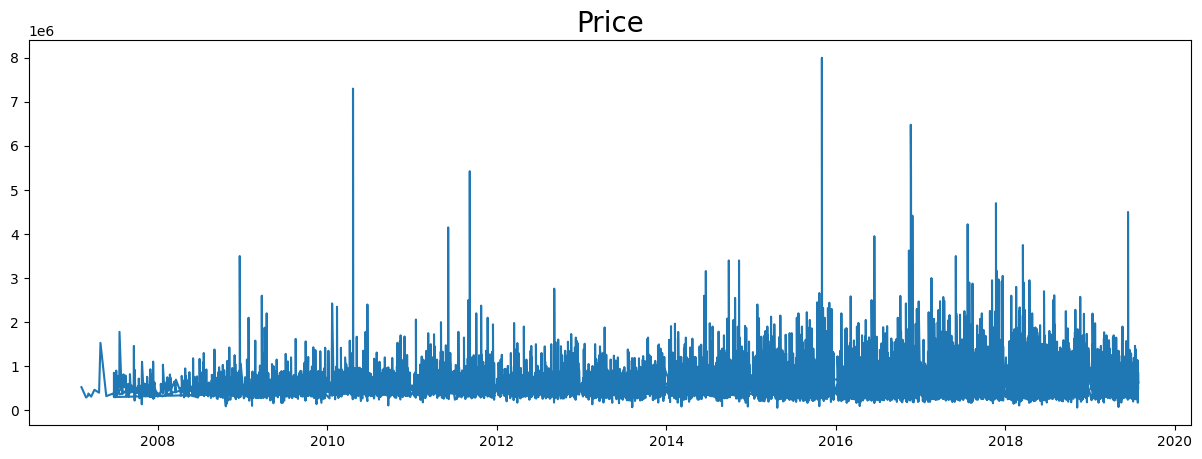

In [8]:
# visualisasi harga rumah berdasarkan tanggal
dates = data['datesold'].values
price = data['price'].values

plt.figure(figsize=(15,5))
plt.plot(dates,price)
plt.title('Price',
          fontsize=20);

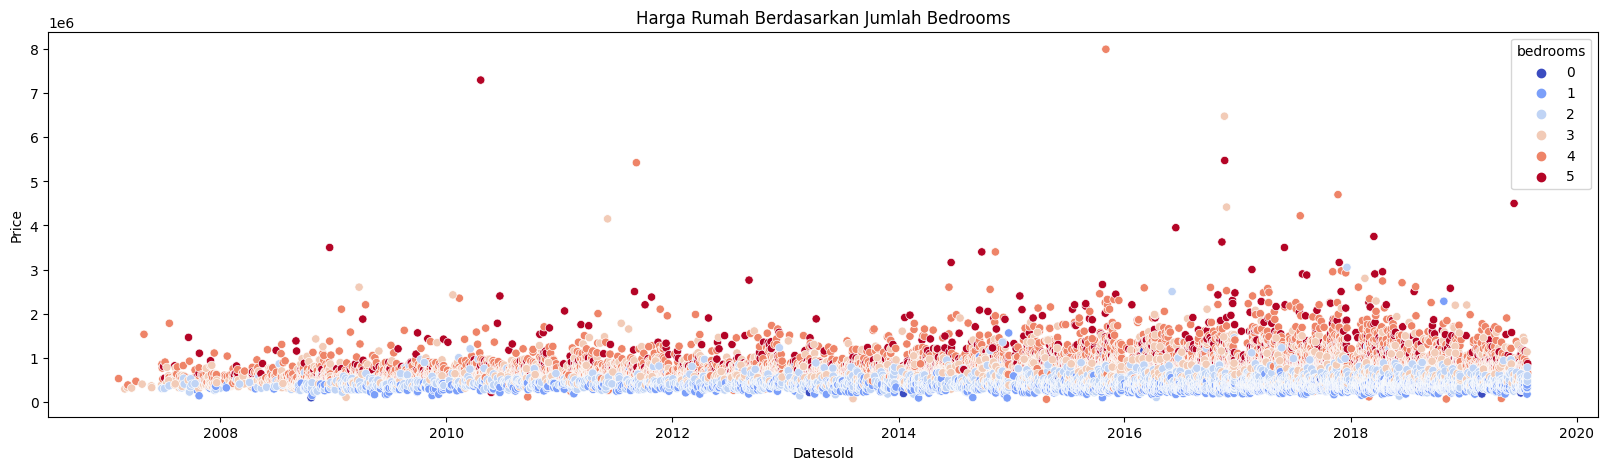

In [9]:
# visualisasi harga rumah berdasarkan tanggal dan bedrooms
fig, ax = plt.subplots(figsize=(20,5))
sns.scatterplot(data=data, x='datesold', y='price', hue='bedrooms',  ax=ax, palette='coolwarm')
ax.set(title='Harga Rumah Berdasarkan Jumlah Bedrooms')
ax.set_ylabel('Price')
ax.set_xlabel('Datesold')
plt.show()

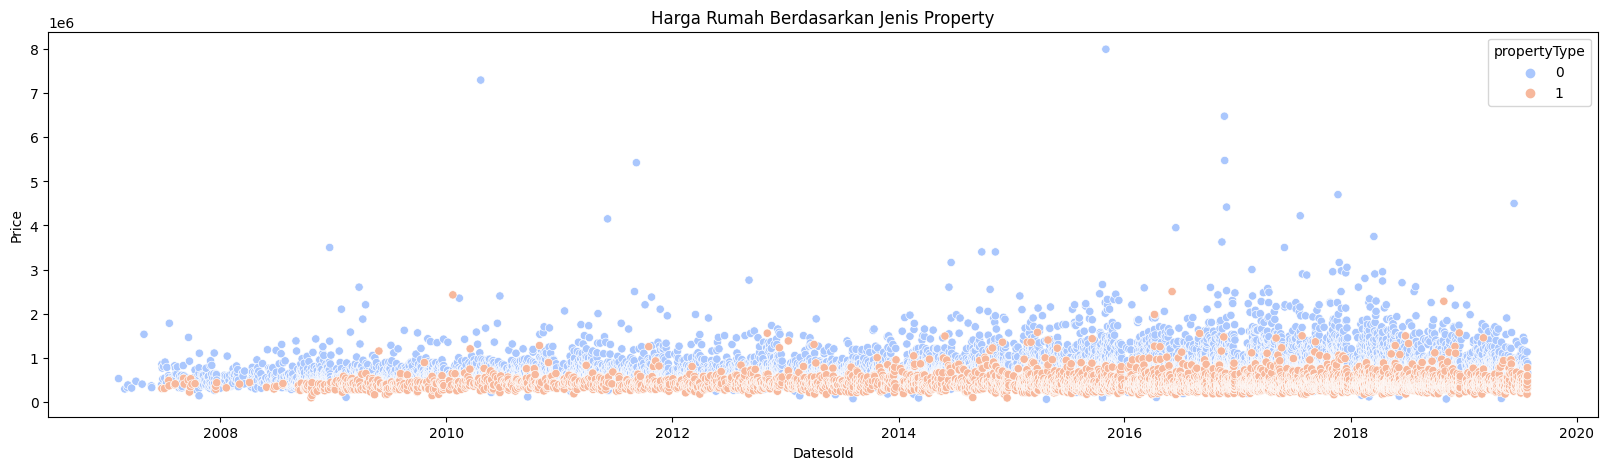

In [24]:
# visualisasi harga rumah berdasarkan tanggal dan jenis property
fig, ax = plt.subplots(figsize=(20,5))
sns.scatterplot(data=data, x='datesold', y='price', hue='propertyType',  ax=ax, palette='coolwarm')
ax.set(title='Harga Rumah Berdasarkan Jenis Property')
ax.set_ylabel('Price')
ax.set_xlabel('Datesold')
plt.show()

In [11]:
# menghitung jumlah masing masing tipe property
data['propertyType'].value_counts()

house    24552
unit      5028
Name: propertyType, dtype: int64

In [12]:
# mengubah kategori tipe property
def change_property(x):
  if x=='house':
    return 0
  else:
    return 1
data['propertyType']=data['propertyType'].apply(change_property)
data.head()

,datesold,postcode,price,propertyType,bedrooms
0,2007-02-07,2607,525000,0,4
1,2007-02-27,2906,290000,0,3
2,2007-03-07,2905,328000,0,3
3,2007-03-09,2905,380000,0,4
4,2007-03-21,2906,310000,0,3


## Preprocessing

In [13]:
# split data
from sklearn.model_selection import train_test_split
x = np.array(data[['postcode','propertyType','bedrooms']])
y = np.array(data[['price']])

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

x = scaler.fit_transform(x)
y = scaler.fit_transform(y)

xtrain, xtest, ytrain, ytest = train_test_split(x, y,
                                                test_size=0.2,
                                                random_state=42, shuffle=False)

## Modelling

In [14]:
# membuat model
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
model = Sequential()
model.add(LSTM(64, return_sequences=True,
               input_shape= (xtrain.shape[1], 1)))
model.add(Dense(48))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 64)             16896     
                                                                 
 dense (Dense)               (None, 3, 48)             3120      
                                                                 
 dropout (Dropout)           (None, 3, 48)             0         
                                                                 
 dense_1 (Dense)             (None, 3, 1)              49        
                                                                 
Total params: 20065 (78.38 KB)
Trainable params: 20065 (78.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
# menentukan optimizer dan menerapkan learning rate
from keras.optimizers import Adam

optimizer = Adam(learning_rate=0.00001)

In [20]:
# menetapkan callbacks dengan nilai mae 0.075 dari jumlah data
from tensorflow.keras.callbacks import EarlyStopping
mae_threshold = 0.075 * np.max(ytrain)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=5, min_delta=mae_threshold)

In [21]:
# training model
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,metrics=["mae"])
history = model.fit(xtrain,ytrain,epochs=100,batch_size=32,validation_data=(xtest,ytest),callbacks=[early_stopping])

Epoch 1/100
740/740 [==============================] - 10s 7ms/step - loss: 0.0084 - mae: 0.1022 - val_loss: 0.0092 - val_mae: 0.0990
Epoch 2/100
740/740 [==============================] - 5s 7ms/step - loss: 0.0062 - mae: 0.0870 - val_loss: 0.0071 - val_mae: 0.0869
Epoch 3/100
740/740 [==============================] - 6s 8ms/step - loss: 0.0047 - mae: 0.0766 - val_loss: 0.0056 - val_mae: 0.0771
Epoch 4/100
740/740 [==============================] - 5s 7ms/step - loss: 0.0038 - mae: 0.0690 - val_loss: 0.0045 - val_mae: 0.0701
Epoch 5/100
740/740 [==============================] - 6s 8ms/step - loss: 0.0031 - mae: 0.0630 - val_loss: 0.0036 - val_mae: 0.0650
Epoch 6/100
740/740 [==============================] - 6s 8ms/step - loss: 0.0027 - mae: 0.0590 - val_loss: 0.0029 - val_mae: 0.0606


## Visualisasi Training dan Validation

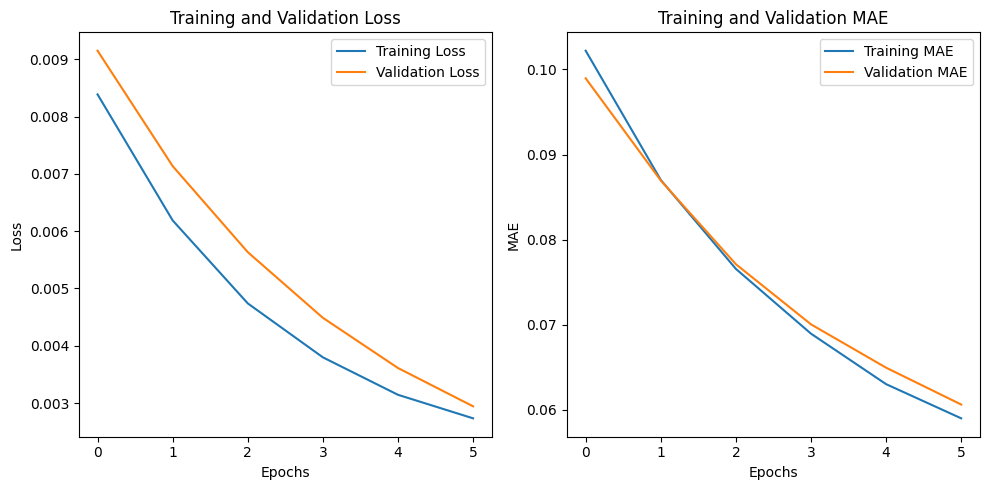

In [22]:
# plot training dan validation data
plt.figure(figsize=(10, 5))

loss = history.history['loss']
val_loss = history.history['val_loss']
mae = history.history['mae']
val_mae = history.history['val_mae']

plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [23]:
# Nilai MAE
loss, mae = model.evaluate(xtest, ytest)
print(f'MAE: {mae}')

185/185 [==============================] - 1s 4ms/step - loss: 0.0029 - mae: 0.0606
MAE: 0.060640398412942886
